In [ ]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuring dataset paths for merging

In [ ]:
# -------------------------------
# CONFIG
# -------------------------------
dataset1 = "/content/drive/MyDrive/MTP_images/train"   # First dataset folder
dataset2 = "/content/drive/MyDrive/MTP_images/validation"   # Second dataset folder
output_dir = "dataset_merged"  # Output merged dataset folder
split_ratio = [0.7, 0.15, 0.15]  # train, val, test

# -------------------------------
# STEP 1: Collect class names
# -------------------------------
classes = os.listdir(dataset2)
print("Classes:", classes)

Classes: ['stop', 'three', 'one', 'up', 'two', 'four', 'down']


In [ ]:
classes[0]

'stop'

In [ ]:
# -------------------------------
# STEP 2: Merge datasets
# -------------------------------
merged_dir = os.path.join(output_dir, "all_images")
os.makedirs(merged_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(merged_dir, cls), exist_ok=True)

    # Get all images from dataset1 + dataset2
    imgs1 = glob(os.path.join(dataset1, cls, "*"))
    imgs2 = glob(os.path.join(dataset2, cls, "*"))
    all_imgs = imgs1 + imgs2

    print(f"Merging {cls}: {len(all_imgs)} images")

    # Copy images into merged folder with unique names
    for i, img_path in enumerate(all_imgs):
        ext = os.path.splitext(img_path)[1]
        new_name = f"{cls}_{i}{ext}"
        shutil.copy(img_path, os.path.join(merged_dir, cls, new_name))

## Merged image dataset is already in drive.
## we can fetch from there.
## No need to merge again.

In [ ]:
path_to_drive = "/content/drive/MyDrive/MTP_images/dataset_merged"
from_path = "/content/dataset_merged/all_images"
# shutil.copytree(from_path, path_to_drive)

In [ ]:
# -------------------------------
# STEP 3: Shuffle + Split
# -------------------------------
splits = ["train", "val", "test"]

for cls in classes:
    imgs = glob(os.path.join(path_to_drive, cls, "*"))
    random.shuffle(imgs)

    n_total = len(imgs)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)

    split_data = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    # Create output folders
    for split in splits:
        split_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img_path in tqdm(split_data[split], desc=f"{cls}-{split}"):
            shutil.copy(img_path, split_dir)

print("✅ Dataset merged, shuffled, and split successfully!")


down-test: 100%|██████████| 137/137 [00:00<00:00, 359.00it/s]

✅ Dataset merged, shuffled, and split successfully!


## Image transformation block

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np

# -------------------------------
# CONFIG
# -------------------------------
data_dir = "dataset_merged"  # parent folder containing train/val/test
batch_size = 32
img_size = 224  # for CNNs like ResNet

# -------------------------------
# STEP 4: Define Transforms
# -------------------------------
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # mean (ImageNet)
                         [0.229, 0.224, 0.225])  # std (ImageNet)
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# -------------------------------
# STEP 5: Load Datasets
# -------------------------------
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)

class_names = train_dataset.classes
print("Classes:", class_names)

# -------------------------------
# STEP 6: Handle Imbalance with WeightedRandomSampler
# -------------------------------
targets = [label for _, label in train_dataset.samples]
class_sample_count = np.array([len(np.where(np.array(targets) == t)[0]) for t in np.unique(targets)])
print("Class distribution:", dict(zip(class_names, class_sample_count)))

weights = 1. / class_sample_count
sample_weights = np.array([weights[t] for t in targets])

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


Classes: ['down', 'four', 'one', 'stop', 'three', 'two', 'up']
Class distribution: {'down': np.int64(634), 'four': np.int64(621), 'one': np.int64(1408), 'stop': np.int64(471), 'three': np.int64(1152), 'two': np.int64(524), 'up': np.int64(681)}


In [ ]:
# -------------------------------
# STEP 7: Create DataLoaders
# -------------------------------
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("✅ DataLoaders ready!")


✅ DataLoaders ready!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Function for model training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# -------------------------------
# CONFIG
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
num_epochs = 20
learning_rate = 1e-4

# -------------------------------
# MODEL: ResNet18 Pretrained
# -------------------------------
model = models.resnet18(pretrained=True)

# Freeze all layers (optional: you can unfreeze later for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# -------------------------------
# LOSS + OPTIMIZER
# -------------------------------
criterion = nn.CrossEntropyLoss()  # (can pass class weights if needed)
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# -------------------------------
# TRAINING LOOP
# -------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*20)

        # TRAINING
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total
        train_loss = train_loss / total

        # VALIDATION
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        val_loss = val_loss / val_total

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet18.pth")
            print("✅ Saved Best Model")

    print(f"\nTraining complete. Best Val Acc: {best_val_acc:.2f}%")

    return model

# -------------------------------
# RUN TRAINING
# -------------------------------
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]



Epoch 1/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.60it/s]


Train Loss: 1.8753, Train Acc: 27.03%
Val Loss: 1.6253, Val Acc: 44.94%
✅ Saved Best Model

Epoch 2/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 1.5465, Train Acc: 56.13%
Val Loss: 1.3866, Val Acc: 58.21%
✅ Saved Best Model

Epoch 3/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.68it/s]


Train Loss: 1.3157, Train Acc: 68.40%
Val Loss: 1.1992, Val Acc: 65.62%
✅ Saved Best Model

Epoch 4/20
--------------------


100%|██████████| 172/172 [00:48<00:00,  3.57it/s]


Train Loss: 1.1462, Train Acc: 74.74%
Val Loss: 1.0225, Val Acc: 74.98%
✅ Saved Best Model

Epoch 5/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.72it/s]


Train Loss: 1.0154, Train Acc: 78.69%
Val Loss: 0.9423, Val Acc: 76.00%
✅ Saved Best Model

Epoch 6/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.75it/s]


Train Loss: 0.9190, Train Acc: 80.55%
Val Loss: 0.8196, Val Acc: 81.02%
✅ Saved Best Model

Epoch 7/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.61it/s]


Train Loss: 0.8463, Train Acc: 81.88%
Val Loss: 0.7554, Val Acc: 82.55%
✅ Saved Best Model

Epoch 8/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.76it/s]


Train Loss: 0.8001, Train Acc: 82.24%
Val Loss: 0.6992, Val Acc: 83.40%
✅ Saved Best Model

Epoch 9/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.73it/s]


Train Loss: 0.7316, Train Acc: 84.12%
Val Loss: 0.6639, Val Acc: 83.91%
✅ Saved Best Model

Epoch 10/20
--------------------


100%|██████████| 172/172 [00:48<00:00,  3.57it/s]


Train Loss: 0.6945, Train Acc: 84.74%
Val Loss: 0.6348, Val Acc: 84.60%
✅ Saved Best Model

Epoch 11/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.66it/s]


Train Loss: 0.6550, Train Acc: 85.45%
Val Loss: 0.6010, Val Acc: 85.79%
✅ Saved Best Model

Epoch 12/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.68it/s]


Train Loss: 0.6244, Train Acc: 86.00%
Val Loss: 0.5851, Val Acc: 85.87%
✅ Saved Best Model

Epoch 13/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.65it/s]


Train Loss: 0.5890, Train Acc: 86.61%
Val Loss: 0.5499, Val Acc: 85.70%

Epoch 14/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.59it/s]


Train Loss: 0.5675, Train Acc: 87.12%
Val Loss: 0.5233, Val Acc: 87.06%
✅ Saved Best Model

Epoch 15/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.70it/s]


Train Loss: 0.5519, Train Acc: 87.20%
Val Loss: 0.4945, Val Acc: 89.11%
✅ Saved Best Model

Epoch 16/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.75it/s]


Train Loss: 0.5403, Train Acc: 86.81%
Val Loss: 0.4673, Val Acc: 89.96%
✅ Saved Best Model

Epoch 17/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.67it/s]


Train Loss: 0.5141, Train Acc: 87.83%
Val Loss: 0.4612, Val Acc: 89.45%

Epoch 18/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.75it/s]


Train Loss: 0.5066, Train Acc: 87.76%
Val Loss: 0.4704, Val Acc: 87.15%

Epoch 19/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 0.4902, Train Acc: 87.82%
Val Loss: 0.4054, Val Acc: 91.32%
✅ Saved Best Model

Epoch 20/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.70it/s]


Train Loss: 0.4642, Train Acc: 88.87%
Val Loss: 0.4126, Val Acc: 90.81%

Training complete. Best Val Acc: 91.32%


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MTP_images/best_resnet18.pth")

In [ ]:
torch.save(model, "/content/drive/MyDrive/MTP_images/trained_resnet18_model.pth")

## Model evaluation metrics & checking confusion matrix

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.8919
✅ Precision: 0.8983
✅ Recall: 0.8919
✅ F1 Score: 0.8919

Classification Report:

              precision    recall  f1-score   support

        down       0.93      0.91      0.92       137
        four       0.73      0.96      0.83       134
         one       0.95      0.94      0.95       303
        stop       0.84      0.95      0.89       102
       three       0.86      0.77      0.81       248
         two       0.93      0.77      0.84       113
          up       0.98      0.97      0.98       147

    accuracy                           0.89      1184
   macro avg       0.89      0.90      0.89      1184
weighted avg       0.90      0.89      0.89      1184



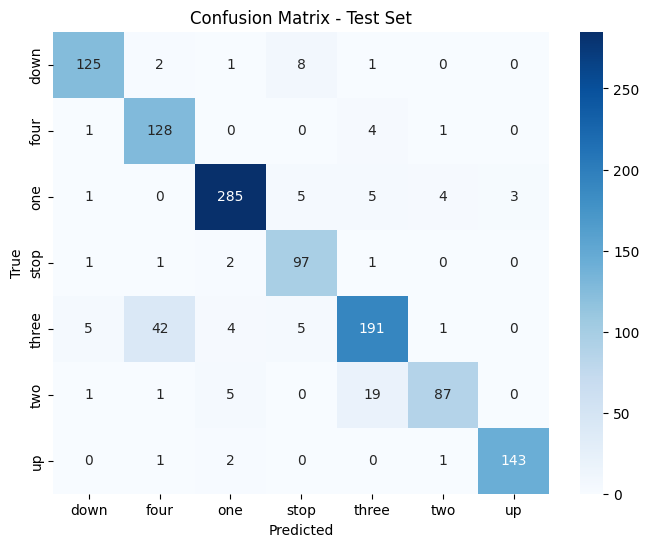

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# LOAD BEST MODEL
# -------------------------------
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("best_resnet18.pth", map_location=device))
model.to(device)
model.eval()

# -------------------------------
# EVALUATE ON TEST SET
# -------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# BASIC METRICS
# -------------------------------
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔹 Per-Class Accuracy:
down: 91.24%
four: 95.52%
one: 94.06%
stop: 95.10%
three: 77.02%
two: 76.99%
up: 97.28%


/tmp/ipython-input-367820715.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.classes, y=per_class_acc, palette="viridis")


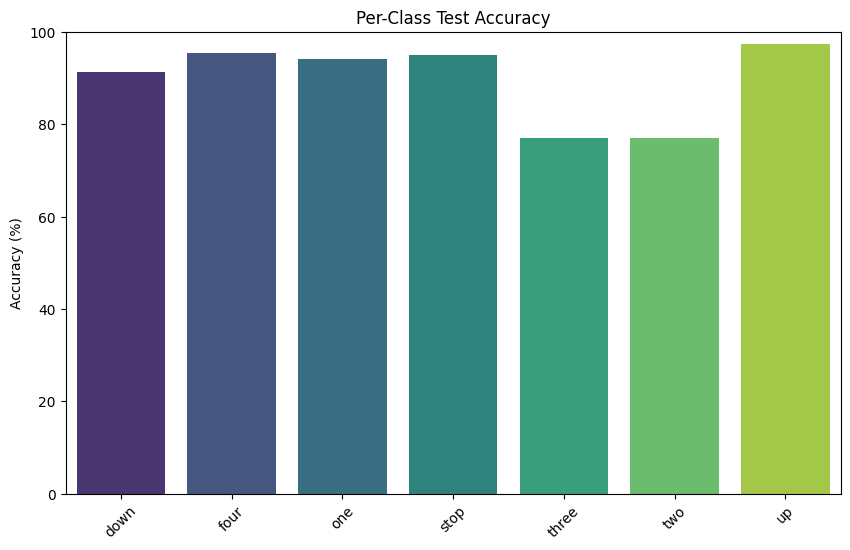

In [ ]:
import numpy as np

# -------------------------------
# PER-CLASS ACCURACY
# -------------------------------
class_correct = [0 for _ in range(num_classes)]
class_total = [0 for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

per_class_acc = [100 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]

# Print per-class results
print("\n🔹 Per-Class Accuracy:")
for i, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {per_class_acc[i]:.2f}%")

# -------------------------------
# PLOT PER-CLASS ACCURACY
# -------------------------------
plt.figure(figsize=(10,6))
sns.barplot(x=train_dataset.classes, y=per_class_acc, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Test Accuracy")
plt.ylim(0, 100)
plt.show()


## Accuracy for class 'three' & 'two' is underperforming. That's why we need class-weighted CrossEntropyLoss into our training so the model pays more attention to difficult classes (two and three).

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract all training labels
all_train_labels = []
for _, labels in train_loader:
    all_train_labels.extend(labels.numpy())

# Compute weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=all_train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class Weights: tensor([0.9879, 0.9805, 0.9867, 1.0321, 1.0241, 0.9805, 1.0109],
       device='cuda:0')


## Training the new model

In [ ]:
model_new = models.resnet18(pretrained=True)

# Freeze all layers (you can unfreeze later for fine-tuning)
for param in model_new.parameters():
    param.requires_grad = False

# Replace final fully connected layer
in_features = model_new.fc.in_features
model_new.fc = nn.Linear(in_features, num_classes)

model_new = model_new.to(device)

# -------------------------------
# LOSS + OPTIMIZER
# -------------------------------
criterion_new = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_new.fc.parameters(), lr=learning_rate)

# -------------------------------
# TRAIN
# -------------------------------
trained_model_new = train_model(
    model_new,
    train_loader,
    val_loader,
    criterion_new,
    optimizer,
    num_epochs
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.73it/s]


Train Loss: 1.9042, Train Acc: 23.38%
Val Loss: 1.7361, Val Acc: 37.70%
✅ Saved Best Model

Epoch 2/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.61it/s]


Train Loss: 1.5555, Train Acc: 52.98%
Val Loss: 1.4231, Val Acc: 58.13%
✅ Saved Best Model

Epoch 3/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.73it/s]


Train Loss: 1.3160, Train Acc: 67.07%
Val Loss: 1.2461, Val Acc: 59.83%
✅ Saved Best Model

Epoch 4/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 1.1546, Train Acc: 75.14%
Val Loss: 1.0922, Val Acc: 64.94%
✅ Saved Best Model

Epoch 5/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.62it/s]


Train Loss: 1.0149, Train Acc: 79.35%
Val Loss: 0.9590, Val Acc: 76.94%
✅ Saved Best Model

Epoch 6/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.72it/s]


Train Loss: 0.9149, Train Acc: 81.48%
Val Loss: 0.8782, Val Acc: 76.85%

Epoch 7/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 0.8508, Train Acc: 82.46%
Val Loss: 0.7848, Val Acc: 81.11%
✅ Saved Best Model

Epoch 8/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.69it/s]


Train Loss: 0.7765, Train Acc: 84.54%
Val Loss: 0.7144, Val Acc: 82.89%
✅ Saved Best Model

Epoch 9/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 0.7307, Train Acc: 84.85%
Val Loss: 0.6766, Val Acc: 83.66%
✅ Saved Best Model

Epoch 10/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.76it/s]


Train Loss: 0.6786, Train Acc: 85.76%
Val Loss: 0.6285, Val Acc: 85.53%
✅ Saved Best Model

Epoch 11/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.69it/s]


Train Loss: 0.6521, Train Acc: 85.87%
Val Loss: 0.5938, Val Acc: 85.19%

Epoch 12/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.75it/s]


Train Loss: 0.6152, Train Acc: 87.07%
Val Loss: 0.5672, Val Acc: 86.89%
✅ Saved Best Model

Epoch 13/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.76it/s]


Train Loss: 0.6054, Train Acc: 85.87%
Val Loss: 0.5195, Val Acc: 89.36%
✅ Saved Best Model

Epoch 14/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.65it/s]


Train Loss: 0.5718, Train Acc: 87.32%
Val Loss: 0.5044, Val Acc: 88.43%

Epoch 15/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.70it/s]


Train Loss: 0.5571, Train Acc: 87.27%
Val Loss: 0.4983, Val Acc: 87.91%

Epoch 16/20
--------------------


100%|██████████| 172/172 [00:45<00:00,  3.76it/s]


Train Loss: 0.5186, Train Acc: 88.24%
Val Loss: 0.4692, Val Acc: 89.19%

Epoch 17/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.66it/s]


Train Loss: 0.5126, Train Acc: 88.22%
Val Loss: 0.4628, Val Acc: 89.28%

Epoch 18/20
--------------------


100%|██████████| 172/172 [00:47<00:00,  3.59it/s]


Train Loss: 0.4965, Train Acc: 88.33%
Val Loss: 0.4278, Val Acc: 90.55%
✅ Saved Best Model

Epoch 19/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.73it/s]


Train Loss: 0.4900, Train Acc: 88.49%
Val Loss: 0.4243, Val Acc: 91.23%
✅ Saved Best Model

Epoch 20/20
--------------------


100%|██████████| 172/172 [00:46<00:00,  3.71it/s]


Train Loss: 0.4721, Train Acc: 89.00%
Val Loss: 0.4318, Val Acc: 90.47%

Training complete. Best Val Acc: 91.23%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔹 Per-Class Accuracy:
down: 88.32%
four: 94.78%
one: 87.79%
stop: 97.06%
three: 82.26%
two: 82.30%
up: 97.96%


/tmp/ipython-input-3131096691.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.classes, y=per_class_acc, palette="viridis")


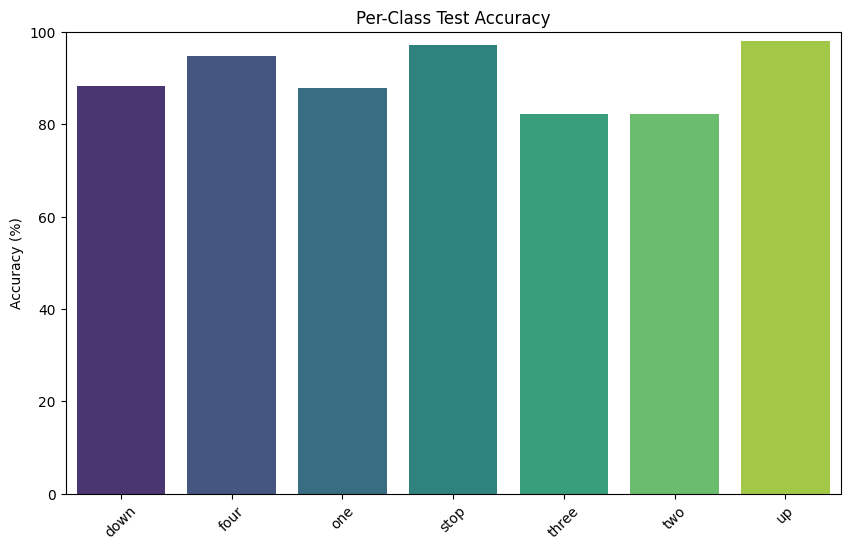

In [ ]:
import numpy as np

# -------------------------------
# PER-CLASS ACCURACY
# -------------------------------
class_correct = [0 for _ in range(num_classes)]
class_total = [0 for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_new(images)
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

per_class_acc = [100 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]

# Print per-class results
print("\n🔹 Per-Class Accuracy:")
for i, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {per_class_acc[i]:.2f}%")

# -------------------------------
# PLOT PER-CLASS ACCURACY
# -------------------------------
plt.figure(figsize=(10,6))
sns.barplot(x=train_dataset.classes, y=per_class_acc, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Test Accuracy")
plt.ylim(0, 100)
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


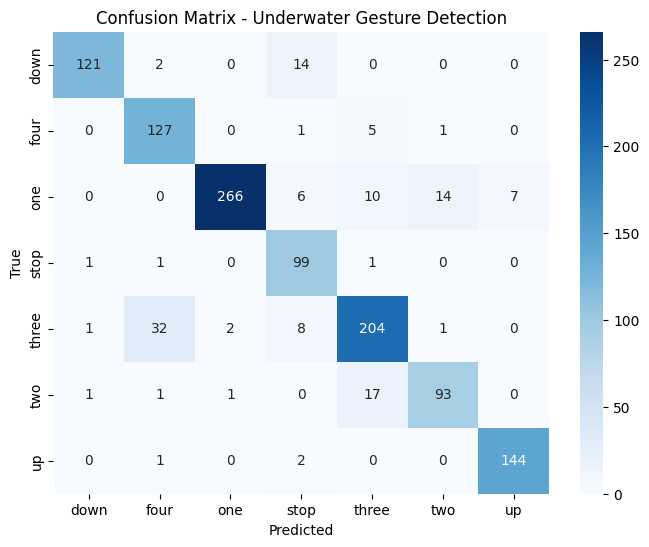

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Put model in eval mode
trained_model_new.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model_new(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  # class order from your ImageFolder

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Underwater Gesture Detection")
plt.show()


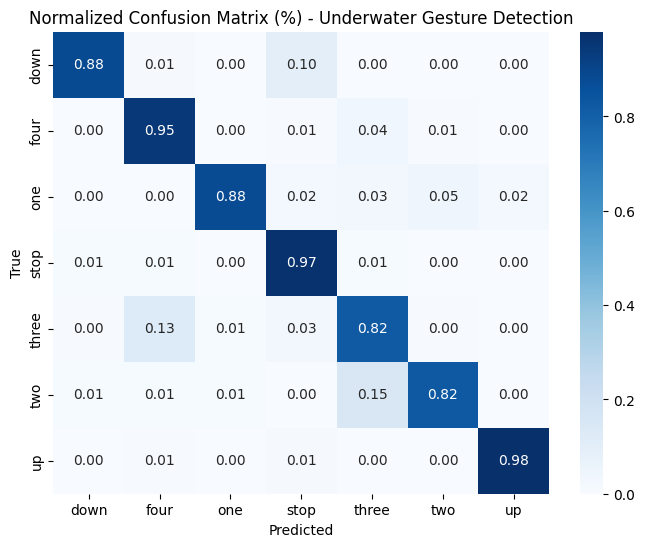

In [ ]:
import numpy as np

# Normalize confusion matrix (row-wise → per-class percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (%) - Underwater Gesture Detection")
plt.show()
